In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ==========================================
# STEP 1 : INSTALL REQUIRED PACKAGES
# ==========================================
!pip install shap lime xgboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
# ==========================================
# STEP 2 : IMPORT LIBRARIES
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import shap
import xgboost as xgb
from lime.lime_tabular import LimeTabularExplainer

RND = 42
np.random.seed(RND)


In [7]:
# ==========================================
# STEP 3 : UPLOAD YOUR CSV FILE (credit_risk_sample.csv)
# ==========================================
df = pd.read_csv('/content/drive/MyDrive/credit_risk_sample.csv')
df.head()


,loan_amnt,annual_income,dti,credit_score,employment_length,num_open_accounts,recent_missed_payments,purpose,default
0,16795,31174,44.88,712,11,5,3,home,1
1,1860,108461,40.45,623,1,3,2,debt_consolidation,0
2,39158,146174,26.34,782,5,5,0,small_business,0
3,12284,123033,41.37,773,16,17,3,debt_consolidation,0
4,7265,29348,1.23,609,2,19,4,small_business,0


In [8]:
# ==========================================
# STEP 4 : BASIC EDA
# ==========================================
df.info()
df.describe()
df.isna().mean().sort_values(ascending=False).head()
df['default'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loan_amnt               500 non-null    int64  
 1   annual_income           500 non-null    int64  
 2   dti                     500 non-null    float64
 3   credit_score            500 non-null    int64  
 4   employment_length       500 non-null    int64  
 5   num_open_accounts       500 non-null    int64  
 6   recent_missed_payments  500 non-null    int64  
 7   purpose                 500 non-null    object 
 8   default                 500 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 35.3+ KB


,count
default,
0,402
1,98


In [10]:
# ==========================================
# STEP 5 : PREPROCESSING PIPELINES
# ==========================================
target = 'default'

X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
     OneHotEncoder(handle_unknown='ignore', sparse_output=False)

])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


In [11]:
# ==========================================
# STEP 6 : TRAIN / TEST SPLIT
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RND
)

In [13]:
# ==========================================
# STEP 7 : APPLY PREPROCESSOR TO DATA
# ==========================================

# 1. Column lists
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

# 2. Numeric pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# 3. If categorical columns exist
if len(cat_cols) > 0:
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

else:
    # No categorical columns
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols)
    ])

# 4. Apply transform safely
X_train_p = preprocessor.fit_transform(X_train)
X_test_p  = preprocessor.transform(X_test)

# 5. Get feature names safely
if len(cat_cols) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([num_cols, cat_names])
else:
    feature_names = num_cols


In [14]:
# ==========================================
# STEP 8 : TRAIN XGBOOST MODEL
# ==========================================
dtrain = xgb.DMatrix(X_train_p, label=y_train)
dtest  = xgb.DMatrix(X_test_p, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.05,
    'seed': RND
}

bst = xgb.train(params, dtrain, num_boost_round=200)


In [15]:
# ==========================================
# STEP 9 : MODEL PERFORMANCE EVALUATION
# ==========================================
proba = bst.predict(dtest)
preds = (proba >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, proba))
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds))
print("Recall:", recall_score(y_test, preds))
print("F1:", f1_score(y_test, preds))


AUC: 0.49375
Accuracy: 0.75
Precision: 0.0
Recall: 0.0
F1: 0.0


/tmp/ipython-input-2689247640.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_p[:2000], feature_names=feature_names)


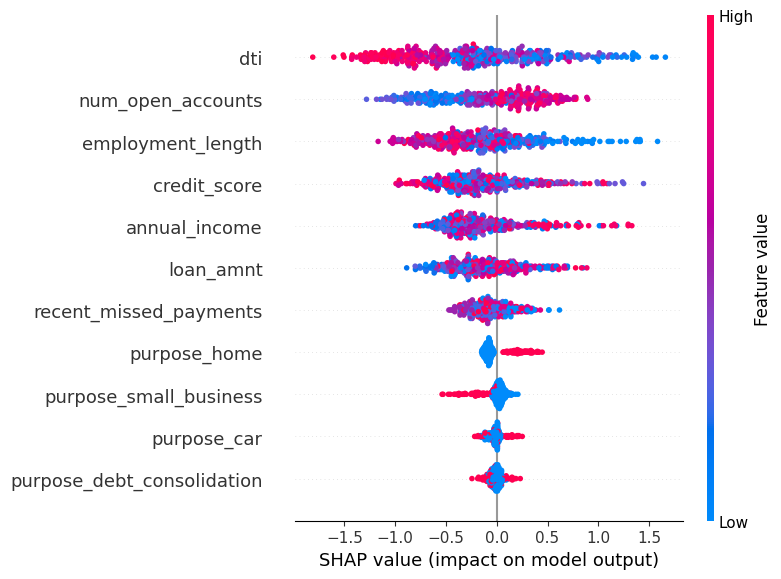

In [16]:
# ==========================================
# STEP 10 : GLOBAL SHAP EXPLANATION
# ==========================================
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train_p[:2000])

shap.summary_plot(shap_values, X_train_p[:2000], feature_names=feature_names)


In [17]:
# ==========================================
# STEP 11 : IDENTIFY 5 BORDERLINE CASES
# ==========================================
df_test = X_test.copy()
df_test['prob'] = proba
df_test['abs_diff'] = np.abs(df_test['prob'] - 0.5)

borderline = df_test.sort_values('abs_diff').head(5)
borderline


,loan_amnt,annual_income,dti,credit_score,employment_length,num_open_accounts,recent_missed_payments,purpose,prob,abs_diff
342,8987,53434,21.82,692,1,12,0,home,0.499433,0.000567
362,10204,38777,18.80,682,3,19,1,debt_consolidation,0.521771,0.021771
456,39756,93479,24.43,807,0,13,4,small_business,0.456855,0.043145
176,3327,104791,19.78,680,3,14,0,home,0.543432,0.043432
111,22518,91726,11.00,595,3,11,2,debt_consolidation,0.404576,0.095424


In [19]:
# ==========================================
# STEP 12 : LIME LOCAL EXPLANATIONS
# ==========================================

# Create a wrapper function for XGBoost predict
def model_predict_proba(input_array):
    dmatrix = xgb.DMatrix(input_array)
    preds = bst.predict(dmatrix)
    # LIME expects 2 columns: [prob_of_class_0, prob_of_class_1]
    return np.column_stack([1 - preds, preds])

# Create LIME explainer
lime_exp = LimeTabularExplainer(
    training_data=X_train_p,
    feature_names=feature_names,
    class_names=['no_default', 'default'],
    discretize_continuous=True
)

# Generate explanation for 5 borderline cases
for idx in borderline.index:
    row = preprocessor.transform(X_test.loc[[idx]])
    exp = lime_exp.explain_instance(
        data_row=row[0],
        predict_fn=model_predict_proba,
        num_features=10
    )
    print("\nCASE:", idx)
    display(exp.as_list())



CASE: 342


[('employment_length <= -0.97', 0.12417486732903843),
 ('-0.83 < credit_score <= 0.02', 0.06445373866553912),
 ('-0.87 < dti <= 0.03', 0.060153124551810176),
 ('-0.06 < num_open_accounts <= 0.93', 0.058771096994317366),
 ('recent_missed_payments <= -0.78', 0.038510448697145504),
 ('purpose_small_business <= 0.00', 0.037278388468610354),
 ('purpose_home > 0.00', 0.036317606869093695),
 ('-0.93 < annual_income <= -0.05', -0.0323114007809196),
 ('-0.95 < loan_amnt <= 0.01', -0.023936941018634604),
 ('purpose_car <= 0.00', -0.00556524441948309)]


CASE: 362


[('employment_length <= -0.97', 0.13546026444130246),
 ('num_open_accounts > 0.93', 0.06596838023899337),
 ('-0.87 < dti <= 0.03', 0.05746972964303132),
 ('-0.83 < credit_score <= 0.02', 0.04973225180464357),
 ('purpose_home <= 0.00', -0.037912643112447936),
 ('purpose_small_business <= 0.00', 0.03746626698127095),
 ('recent_missed_payments <= -0.78', 0.028477933459357088),
 ('-0.95 < loan_amnt <= 0.01', -0.01950255501804179),
 ('0.00 < purpose_debt_consolidation <= 1.00', 0.006867049509311284),
 ('purpose_car <= 0.00', -0.0011644422807817309)]


CASE: 456


[('employment_length <= -0.97', 0.10959084837589292),
 ('-0.06 < num_open_accounts <= 0.93', 0.047829182004077875),
 ('purpose_small_business > 0.00', -0.036568341736002305),
 ('0.03 < dti <= 0.85', -0.03561715843309851),
 ('purpose_home <= 0.00', -0.030648489046385435),
 ('-0.05 < annual_income <= 0.94', -0.027427842136630028),
 ('loan_amnt > 0.84', 0.020127460211065436),
 ('credit_score > 0.83', 0.015965516401843807),
 ('recent_missed_payments > 0.66', -0.00947700626594125),
 ('purpose_car <= 0.00', 0.007243987190342715)]


CASE: 176


[('employment_length <= -0.97', 0.12378209026857998),
 ('-0.87 < dti <= 0.03', 0.07424426178154821),
 ('-0.83 < credit_score <= 0.02', 0.04891874637658729),
 ('-0.06 < num_open_accounts <= 0.93', 0.04820613039486494),
 ('purpose_small_business <= 0.00', 0.03237270890148358),
 ('purpose_home > 0.00', 0.030262442367096104),
 ('recent_missed_payments <= -0.78', 0.02817258269238503),
 ('-0.05 < annual_income <= 0.94', -0.024198212806398348),
 ('loan_amnt <= -0.95', 0.017817788906595085),
 ('purpose_car <= 0.00', -0.011534726199474482)]


CASE: 111


[('employment_length <= -0.97', 0.12519831764591374),
 ('dti <= -0.87', 0.0900665601502359),
 ('-0.06 < num_open_accounts <= 0.93', 0.047114756979848335),
 ('purpose_small_business <= 0.00', 0.03647733475693745),
 ('purpose_home <= 0.00', -0.03581902395022007),
 ('-0.78 < recent_missed_payments <= -0.06', -0.03246779614656249),
 ('-0.05 < annual_income <= 0.94', -0.028214794682403715),
 ('credit_score <= -0.83', -0.02360054327438354),
 ('0.00 < purpose_debt_consolidation <= 1.00', 0.015324494866783112),
 ('purpose_car <= 0.00', 0.008360961353939851)]

In [20]:
# ==========================================
# STEP 14 : SAVE BORDERLINE CASES TO CSV
# ==========================================

borderline_output = borderline.copy()
borderline_output.to_csv("borderline_cases.csv", index=True)

print("Saved as borderline_cases.csv")


Saved as borderline_cases.csv


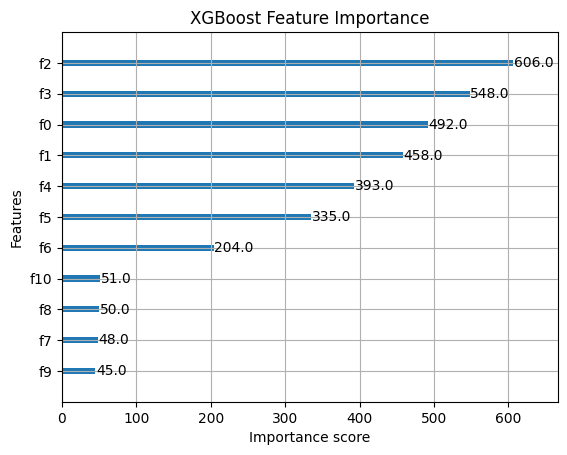

In [21]:
# ==========================================
# STEP 15 : XGBOOST FEATURE IMPORTANCE
# ==========================================

xgb.plot_importance(bst, max_num_features=20)
plt.title("XGBoost Feature Importance")
plt.show()


In [22]:
# ==========================================
# STEP 16 : PRINT FINAL SUMMARY
# ==========================================

print("MODEL PERFORMANCE SUMMARY")
print("---------------------------")
print("AUC        :", roc_auc_score(y_test, proba))
print("Accuracy   :", accuracy_score(y_test, preds))
print("Precision  :", precision_score(y_test, preds))
print("Recall     :", recall_score(y_test, preds))
print("F1 Score   :", f1_score(y_test, preds))

print("\nTop 5 Borderline Cases:")
display(borderline)


MODEL PERFORMANCE SUMMARY
---------------------------
AUC        : 0.49375
Accuracy   : 0.75
Precision  : 0.0
Recall     : 0.0
F1 Score   : 0.0

Top 5 Borderline Cases:


,loan_amnt,annual_income,dti,credit_score,employment_length,num_open_accounts,recent_missed_payments,purpose,prob,abs_diff
342,8987,53434,21.82,692,1,12,0,home,0.499433,0.000567
362,10204,38777,18.80,682,3,19,1,debt_consolidation,0.521771,0.021771
456,39756,93479,24.43,807,0,13,4,small_business,0.456855,0.043145
176,3327,104791,19.78,680,3,14,0,home,0.543432,0.043432
111,22518,91726,11.00,595,3,11,2,debt_consolidation,0.404576,0.095424
